In [1]:
!pip install transformers torch pandas scikit-learn pypdf 

In [10]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, BertConfig, AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from pypdf import PdfReader 

# Example data loading function (replace this with actual PDF data extraction logic)
def load_data():
    data1 = PdfReader('/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-1917-2023.pdf').pages[0].extract_text()
    data2 = PdfReader('/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-1458-20230314.pdf').pages[0].extract_text()
    if len(data1) > 512:
        data1 = data1[174:686]
    if len(data2) > 512:
        data2 = data2[174:686]
    return pd.DataFrame({"text1": [data1], "text2": [data2]})

data = load_data()


In [15]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-large")
model = AutoModel.from_pretrained("vinai/phobert-large")

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, BertConfig, AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from pypdf import PdfReader 

In [3]:
def tokenize_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    return inputs

data['tokens1'] = data['text1'].apply(tokenize_text)
data['tokens2'] = data['text2'].apply(tokenize_text)

NameError: name 'data' is not defined

In [25]:
temp = PdfReader('/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-1917-2023.pdf').pages[0].extract_text()
len(temp[:512])

512

In [4]:
def get_embeddings(tokens):
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1)

data['embeddings1'] = data['tokens1'].apply(get_embeddings)
data['embeddings2'] = data['tokens2'].apply(get_embeddings)

NameError: name 'data' is not defined

In [10]:
def calculate_similarity(emb1, emb2):
    emb1_np = emb1.numpy()
    emb2_np = emb2.numpy()
    return cosine_similarity(emb1_np, emb2_np)[0][0]

data['similarity'] = data.apply(lambda row: calculate_similarity(row['embeddings1'], row['embeddings2']), axis=1)

NameError: name 'data' is not defined

In [28]:
print(data[['text1', 'text2', 'similarity']])

                                               text1  \
0  V/v thí điểm áp dụng quy trình phát \ntriển ph...   

                                               text2  similarity  
0  \n \n \nTHÔNG BÁO  \nKết luận của ông Trình Tr...     0.98811  


In [30]:
print(data["text2"].values[0])


 
 
THÔNG BÁO  
Kết luận của ông Trình Trung Phương - Tổ trưởng tổ công tác  số 2 
tại cuộc họp Tổ công tác chuyển đổi số quản trị doanh nghiệp ( CĐS QTDN ) 
– Phiên họp 8  
 
Ngày 07/3/2023, Tổ công tác chuyển đổi số quản trị doanh nghiệp (Tổ công tác số 
2) đã tổ chức cuộc họp phiên  họp 8 do ông Trình Trung Phương - Thành viên  HĐTV 
EVNCPC, Tổ trưởng Tổ công tác số 2 chủ tr ì; Tham dự cuộc họp có Thường trực  và 
các thành viên Tổ công tác tại các Ban EVNCPC, đại diện Lãnh đạo CPCIT (thành phần 
tham g


In [8]:
import torch
import numpy as np
from transformers import LongformerTokenizer, LongformerModel, AutoTokenizer, RobertaForMaskedLM
from transformers.models.longformer.modeling_longformer import LongformerSelfAttention
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Custom tokenizer and model
class RobertaLongSelfAttention(LongformerSelfAttention):
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value = None,
        output_attentions=False,
    ):
        attention_mask = attention_mask.squeeze(dim=2).squeeze(dim=1)
        is_index_masked = attention_mask < 0
        is_index_global_attn = attention_mask > 0
        is_global_attn = any(is_index_global_attn.flatten())
        return super().forward(hidden_states, 
                               is_index_masked=is_index_masked, 
                               is_index_global_attn=is_index_global_attn, 
                               is_global_attn=is_global_attn,
                               attention_mask=attention_mask, 
                               output_attentions=output_attentions)

class RobertaLongForMaskedLM(RobertaForMaskedLM):
    def __init__(self, config):
        super().__init__(config)
        for i, layer in enumerate(self.roberta.encoder.layer):
            layer.attention.self = RobertaLongSelfAttention(config, layer_id=i)
    

# Load Longformer model and tokenizer
model_name = 'bluenguyen/longformer-phobert-base-4096'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaLongForMaskedLM.from_pretrained(model_name)

def preprocess_text_longformer(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=4096)
    return inputs

def get_embeddings_longformer(text):
    inputs = preprocess_text_longformer(text)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

def reduce_dimensions(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Example large documents
doc1 = get_all_text_pdf('/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-1917-2023.pdf')

doc2 = get_all_text_pdf('/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-1458-20230314.pdf')

# Get embeddings
embedding_doc1 = get_embeddings_longformer(doc1)
embedding_doc2 = get_embeddings_longformer(doc2)

# Calculate similarity
similarity_score = cosine_similarity(embedding_doc1, embedding_doc2)[0][0]
print(f"Cosine Similarity between documents: {similarity_score:.4f}")

# Optional: Reduce dimensions
# reduced_embedding_doc1 = reduce_dimensions(embedding_doc1)
# bluenguyen/longformer-phobert-base-4096

AttributeError: 'MaskedLMOutput' object has no attribute 'last_hidden_state'

In [2]:
def get_all_text_pdf(path):
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"
    return text

In [3]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from pypdf import PdfReader 

# Load the PhoBERT-based Longformer model and tokenizer
model_name = 'bluenguyen/longformer-phobert-base-4096'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def preprocess_text_longformer(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=4096)
    return inputs

def get_embeddings_longformer(text):
    inputs = preprocess_text_longformer(text)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs[0]  # Correctly access the hidden states
        embeddings = hidden_states.mean(dim=1).numpy()
    return embeddings

def reduce_dimensions(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Example large documents
doc1 = get_all_text_pdf('/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-1458-20230314.pdf')
doc2 = get_all_text_pdf('/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-3324-20220511.pdf')

embedding_doc1 = get_embeddings_longformer(doc1)
embedding_doc2 = get_embeddings_longformer(doc2)
similarity_score = cosine_similarity(embedding_doc1, embedding_doc2)[0][0]
print(similarity_score)



tokenizer_config.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/916 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/637M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at bluenguyen/longformer-phobert-base-4096 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.98196673


In [ ]:
links = ["/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-1917-2023.pdf", "/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-5632-2023.pdf", "/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-1458-20230314.pdf", "/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-3324-20220511.pdf", "/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-4422-20240703.pdf"]

# Get embeddings
embedding_doc1 = get_embeddings_longformer(doc1)
embedding_doc2 = get_embeddings_longformer(doc2)

res = []
for el1 in links:
    temp = []
    for el2 in links:
        doc1 = get_all_text_pdf(el1)
        doc2 = get_all_text_pdf(el2)
        embedding_doc1 = get_embeddings_longformer(doc1)
        embedding_doc2 = get_embeddings_longformer(doc2)
        similarity_score = cosine_similarity(embedding_doc1, embedding_doc2)[0][0]
        temp.append(similarity_score)
    res.append(temp)

import numpy as np
import matplotlib.pyplot as plt

# Calculate similarity
# similarity_score = cosine_similarity(embedding_doc1, embedding_doc2)[0][0]
# print(f"Cosine Similarity between documents: {similarity_score:.4f}")

# Optional: Reduce dimensions
# reduced_embedding_doc1 = reduce_dimensions(embedding_doc1)
# reduced_embedding_doc2 = reduce_dimensions(embedding_doc2)


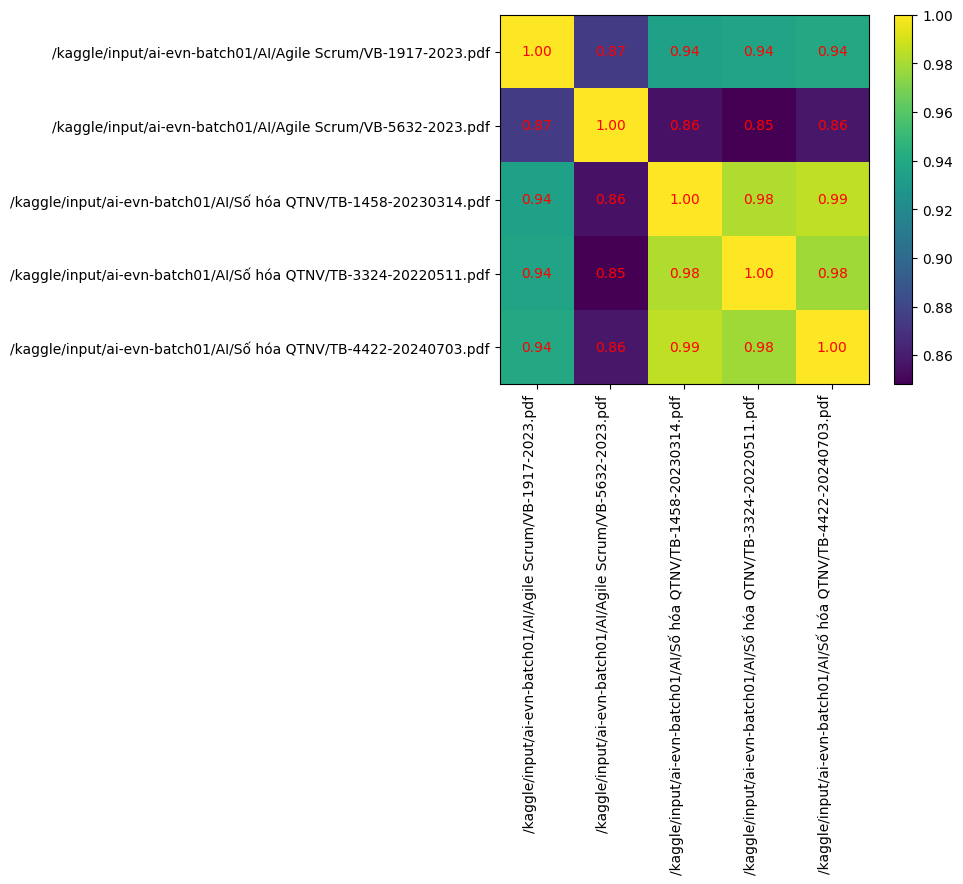

In [80]:
fig, ax = plt.subplots()
plt.imshow(np.array(res))
plt.colorbar()
for i in range(len(res)):
   for j in range(len(res)):
      c = np.array(res)[j, i]
      ax.text(i, j, f"{c:.2f}", va='center', ha='center', color="red")
ax.set_xticks(range(len(links)))
ax.set_yticks(range(len(links)))
ax.set_xticklabels(links, rotation = 90, ha="right")
ax.set_yticklabels(links)
plt.show()

In [65]:
links

['/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-1917-2023.pdf',
 '/kaggle/input/ai-evn-batch01/AI/Agile Scrum/VB-5632-2023.pdf',
 '/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-1458-20230314.pdf',
 '/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-3324-20220511.pdf',
 '/kaggle/input/ai-evn-batch01/AI/Số hóa QTNV/TB-4422-20240703.pdf']